In [1]:
import torch
import numpy as np
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

### A. Visualize DINO Attention Map ###

Using cache found in /home/yaushingjonathancheung/.cache/torch/hub/facebookresearch_dino_main


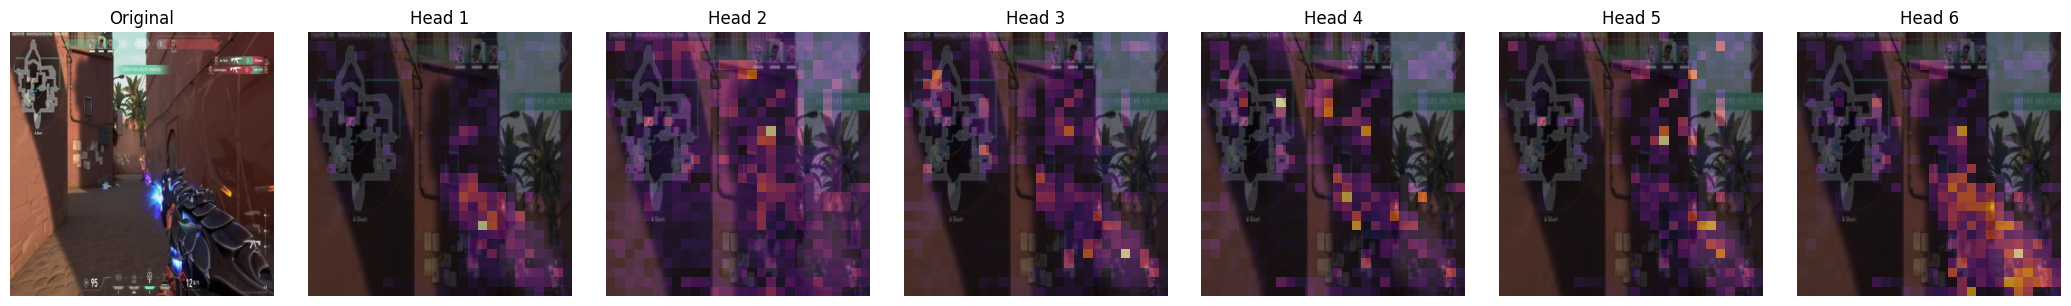

In [2]:
# Load DINO ViT-S/16 backbone
vits8 = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
backbone = vits8.eval()

img_path = "../data/valid/clip2--9-_jpg.rf.32b9d10ccbae55072ccaf2dd3994b6bd.jpg"  
img = Image.open(img_path).convert('RGB')

transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])
input_tensor = transform(img).unsqueeze(0)  # [1, 3, 224, 224]

# --- Hook for Attention Weights ---
attentions = []

def get_attn(module, input, output):
    attentions.append(output[1].detach().cpu())

# Register the forward hook on the last transformer block
hook_handle = backbone.blocks[-1].attn.register_forward_hook(get_attn)

# --- Forward Pass ---
with torch.no_grad():
    _ = backbone(input_tensor)

hook_handle.remove()  

# --- Process attention ---
# attentions[-1]: (batch, heads, tokens, tokens)
attn = attentions[-1][0]  # [HEADS, TOKENS, TOKENS]
nh = attn.shape[0]

# Take the CLS token attention to all patch tokens
cls_attn = attn[:, 0, 1:]  # [HEADS, PATCHES]
cls_attn = cls_attn.reshape(nh, 28, 28)

# --- Visualization ---
fig, axs = plt.subplots(1, nh+1, figsize=(3*(nh+1), 3))
axs[0].imshow(img)
axs[0].set_title('Original')
axs[0].axis('off')

for i in range(nh):
    axs[i+1].imshow(img)
    axs[i+1].imshow(cls_attn[i], cmap='inferno', alpha=0.6, extent=(0,224,224,0))
    axs[i+1].set_title(f'Head {i+1}')
    axs[i+1].axis('off')

plt.tight_layout()
plt.show()

### B. Model Training ###

#### B1. Model Definition ####

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# DETR's transformer decoder
class DETRHead(nn.Module):
    def __init__(self, d_model=384, num_queries=100, num_classes=2):  # 1 class + "no object"
        super().__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=8)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=6)
        self.query_embed = nn.Embedding(num_queries, d_model)
        self.class_embed = nn.Linear(d_model, num_classes)
        self.bbox_embed = MLP(d_model, d_model, 4, 3)  # predicts [cx,cy,w,h] in [0,1]

    def forward(self, src, mask=None):
        bs, c, h, w = src.shape
        src_flat = src.flatten(2).permute(2, 0, 1)      # (h*w, bs, c)
        pos_embed = positionalencoding2d(c, h, w).to(src.device).flatten(1).permute(1, 0).unsqueeze(1).repeat(1, bs, 1)
        queries = self.query_embed.weight.unsqueeze(1).repeat(1, bs, 1)  # (num_queries, bs, d_model)

        tgt = torch.zeros_like(queries)  # (num_queries, bs, d_model)
        hs = self.decoder(tgt, src_flat + pos_embed)  # (num_queries, bs, d_model)

        outputs_class = self.class_embed(hs)
        outputs_coord = self.bbox_embed(hs).sigmoid()
        return outputs_class.transpose(0, 1), outputs_coord.transpose(0, 1)  # (bs, num_queries, ...)

# Simple MLP for bounding box regression
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super().__init__()
        layers = []
        for i in range(num_layers - 1):
            layers.append(nn.Linear(input_dim if i == 0 else hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, output_dim))
        self.mlp = nn.Sequential(*layers)

    def forward(self, x):
        return self.mlp(x)

# 2D positional encoding
def positionalencoding2d(d_model, height, width):
    """
    Generate a 2D positional encoding.
    """
    if d_model % 4 != 0:
        raise ValueError("Cannot use sin/cos positional encoding with odd dim (got dim={:d})".format(d_model))
    pe = torch.zeros(d_model, height, width)
    d_model = int(d_model / 2)
    div_term = torch.exp(torch.arange(0., d_model, 2) * -(torch.log(torch.tensor(10000.0)) / d_model))
    pos_w = torch.arange(0., width).unsqueeze(1)
    pos_h = torch.arange(0., height).unsqueeze(1)
    pe[0:d_model:2, :, :] = torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[1:d_model:2, :, :] = torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    pe[d_model::2, :, :] = torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    pe[d_model + 1::2, :, :] = torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    return pe

# Full Model - DINO backbone + DETR head
class DinoDETR(nn.Module):
    def __init__(self, num_classes=2, num_queries=100):
        super().__init__()
        self.backbone = torch.hub.load('facebookresearch/dino:main', 'dino_vits8')
        self.detr_head = DETRHead(d_model=384, num_queries=num_queries, num_classes=num_classes)
        #self.detr_head = DETRHead(d_model=768, num_queries=num_queries, num_classes=num_classes)

    def forward(self, x):
        #with torch.no_grad():
        feats = self.backbone.get_intermediate_layers(x, n=1)[0]  # (B, num_patches+1, C)
        feat_patches = feats[:, 1:, :]  # remove [CLS] token: (B, num_patches, C)
        # ViT-S/16: 224x224 -> 14x14 patches
        B, N, C = feat_patches.shape
        H = W = int(N ** 0.5)
        feat_map = feat_patches.reshape(B, H, W, C).permute(0, 3, 1, 2)  # (B, C, H, W)
        class_logits, pred_boxes = self.detr_head(feat_map)
        return class_logits, pred_boxes

#### B2. Dataset ####

In [4]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder

class ObjectDetectionDataset(Dataset):
    def __init__(self, img_dir, csv_file, label_encoder, transform=None, imsize=224):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_file)
        self.transform = transform
        self.imsize = imsize
        self.label_encoder = label_encoder
        self.groups = self.df.groupby('filename')
        self.samples = list(self.groups.groups.keys())

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        filename = self.samples[idx]
        records = self.groups.get_group(filename)
        img_path = os.path.join(self.img_dir, filename)
        img = Image.open(img_path).convert('RGB')
        w, h = records.iloc[0]['width'], records.iloc[0]['height']

        boxes = []
        labels = []

        for i, row in records.iterrows():
            # Normalize bbox to [0, 1]
            xmin = row['xmin'] / w
            ymin = row['ymin'] / h
            xmax = row['xmax'] / w
            ymax = row['ymax'] / h
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(self.label_encoder.transform([row['class']])[0])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        labels = torch.tensor(labels, dtype=torch.long)

        if self.transform:
            img = self.transform(img)

        target = {
            'boxes': boxes,  # (num_objects, 4)
            'labels': labels # (num_objects,)
        }
        return img, target


def collate_fn(batch):
    images, targets = zip(*batch)
    images = torch.stack(images)
    return images, targets

In [5]:
from torch.utils.data import Subset

train_dir = '../data/train'
train_csv = os.path.join(train_dir, '_annotations.csv')

# --- Transforms ---
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

df = pd.read_csv(train_csv)

label_encoder = LabelEncoder()
label_encoder.fit(df['class'])
num_classes = len(label_encoder.classes_) + 1 # +1 for background/no-object
print(num_classes)

# Pass this filtered CSV to the dataset
dataset = ObjectDetectionDataset(train_dir, train_csv, label_encoder, transform=transform)
subset = Subset(dataset, range(2000))
loader = DataLoader(subset, batch_size=8, shuffle=True, collate_fn=collate_fn)
#loader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)
#dataset = ObjectDetectionDataset(train_dir, train_csv, label_encoder, transform=transform)

# After creating the dataset
print(dataset.df['class'].unique())

3
['enemy' 'enemy_head']


#### B3. Loss Function ####

In [6]:
from scipy.optimize import linear_sum_assignment
def detr_hungarian_loss(pred_logits, pred_boxes, targets, num_classes, no_object_class=0):
    """
    pred_logits: (B, Q, C) - predicted class logits
    pred_boxes: (B, Q, 4) - predicted boxes in cxcywh
    targets: list of dicts with 'labels' (num_objs,) and 'boxes' (num_objs, 4)
    """
    loss_cls, loss_bbox = 0, 0
    B, Q, C = pred_logits.shape

    for i in range(B):
        tgt_labels = targets[i]['labels'].to(pred_logits.device)
        tgt_boxes = xyxy_to_cxcywh(targets[i]['boxes'].to(pred_logits.device))

        # Compute cost matrix
        out_prob = pred_logits[i].softmax(-1)  # (Q, C)
        out_bbox = pred_boxes[i]  # (Q, 4)

        # Classification cost: negative log-probability
        cost_class = -out_prob[:, tgt_labels]

        # L1 cost between boxes
        cost_bbox = torch.cdist(out_bbox, tgt_boxes, p=1)

        # Combined cost
        C_mat = cost_class + cost_bbox

        # Hungarian matching
        indices = linear_sum_assignment(C_mat.cpu().detach().numpy())
        pred_idx, tgt_idx = indices

        # Classification loss (cross-entropy, including no-object)
        target_classes = torch.full((Q,), no_object_class, dtype=torch.long, device=pred_logits.device)
        target_classes[pred_idx] = tgt_labels[tgt_idx]
        loss_cls += nn.functional.cross_entropy(pred_logits[i], target_classes)

        # Box loss (L1 for matched pairs)
        loss_bbox += nn.functional.l1_loss(out_bbox[pred_idx], tgt_boxes[tgt_idx])

    loss_cls /= B
    loss_bbox /= B
    return loss_cls, loss_bbox

def xyxy_to_cxcywh(boxes):
    # boxes: (N, 4) in [xmin, ymin, xmax, ymax]
    x_c = (boxes[:, 0] + boxes[:, 2]) / 2
    y_c = (boxes[:, 1] + boxes[:, 3]) / 2
    w = boxes[:, 2] - boxes[:, 0]
    h = boxes[:, 3] - boxes[:, 1]
    return torch.stack([x_c, y_c, w, h], dim=1)

#### B4. Model Training ####

In [7]:
def set_trainable_dino_blocks(model, num_unfrozen=2):
    for param in model.backbone.parameters():
        param.requires_grad = False
    for block in model.backbone.blocks[-num_unfrozen:]:
        for param in block.parameters():
            param.requires_grad = True


# ==== Main Training Loop ====
def train():
  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = DinoDETR(num_queries=20, num_classes=num_classes).to(device)
  #optimizer = optim.AdamW(model.parameters(), lr=1e-2)
  set_trainable_dino_blocks(model, num_unfrozen=2)  # Partial fine-tuning!
  optimizer = optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

  # --- Training Loop ---
  num_epochs = 10
  for epoch in range(num_epochs):
      model.train()
      total_loss, total_cls, total_bbox = 0, 0, 0
      for images, targets in tqdm(loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
          images = images.to(device)
          pred_logits, pred_boxes = model(images)
          
          loss_cls, loss_bbox = detr_hungarian_loss(pred_logits, pred_boxes, targets, num_classes)
          loss = loss_cls + loss_bbox
          
          optimizer.zero_grad()
          loss.backward()
          optimizer.step()
          total_loss += loss.item()
          total_cls += loss_cls.item()
          total_bbox += loss_bbox.item()
      steps = len(loader)
      print(f"Epoch {epoch+1}: Avg Loss={total_loss/steps:.4f} Cls={total_cls/steps:.4f} Bbox={total_bbox/steps:.4f}")
  #torch.save(model.state_dict(), f'dino_detr_epoch{epoch+1}_fin_101.pth')
  return model

model = train()


Using cache found in /home/yaushingjonathancheung/.cache/torch/hub/facebookresearch_dino_main
Epoch 1/10: 100%|██████████| 250/250 [01:25<00:00,  2.92it/s]


Epoch 1: Avg Loss=0.2233 Cls=0.1703 Bbox=0.0530


Epoch 2/10: 100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


Epoch 2: Avg Loss=0.1338 Cls=0.1018 Bbox=0.0321


Epoch 3/10: 100%|██████████| 250/250 [01:24<00:00,  2.95it/s]


Epoch 3: Avg Loss=0.1272 Cls=0.0974 Bbox=0.0298


Epoch 4/10: 100%|██████████| 250/250 [01:25<00:00,  2.94it/s]


Epoch 4: Avg Loss=0.1318 Cls=0.1022 Bbox=0.0296


Epoch 5/10: 100%|██████████| 250/250 [01:25<00:00,  2.93it/s]


Epoch 5: Avg Loss=0.1277 Cls=0.0982 Bbox=0.0295


Epoch 6/10: 100%|██████████| 250/250 [01:24<00:00,  2.94it/s]


Epoch 6: Avg Loss=0.1274 Cls=0.0996 Bbox=0.0279


Epoch 7/10: 100%|██████████| 250/250 [01:25<00:00,  2.94it/s]


Epoch 7: Avg Loss=0.1237 Cls=0.0958 Bbox=0.0279


Epoch 8/10: 100%|██████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 8: Avg Loss=0.1255 Cls=0.0969 Bbox=0.0286


Epoch 9/10: 100%|██████████| 250/250 [01:24<00:00,  2.96it/s]


Epoch 9: Avg Loss=0.1221 Cls=0.0950 Bbox=0.0272


Epoch 10/10: 100%|██████████| 250/250 [01:24<00:00,  2.96it/s]

Epoch 10: Avg Loss=0.1209 Cls=0.0943 Bbox=0.0267


In [8]:
import torch
from PIL import Image, ImageDraw
import torchvision
import matplotlib.pyplot as plt

def box_cxcywh_to_xyxy(box, img_size):
    """Convert normalized [cx, cy, w, h] to absolute [x0, y0, x1, y1] in pixels."""
    w_img, h_img = img_size
    cx, cy, bw, bh = box
    x0 = (cx - 0.5 * bw) * w_img
    y0 = (cy - 0.5 * bh) * h_img
    x1 = (cx + 0.5 * bw) * w_img
    y1 = (cy + 0.5 * bh) * h_img
    return [x0, y0, x1, y1]

def box_xyxy_norm_to_abs(box, img_size):
    """Convert normalized [x0, y0, x1, y1] to absolute pixel coordinates."""
    w_img, h_img = img_size
    return [box[0] * w_img, box[1] * h_img, box[2] * w_img, box[3] * h_img]

def decode_label(label, label_encoder):
    """Decode label index to string using label encoder."""
    if isinstance(label, str):
        return label
    return label_encoder.inverse_transform([int(label)])[0]

def run_inference(
    model,
    img_path,
    label_encoder,
    device,
    threshold=0.5,
    imsize=224,
    gt_boxes=None,
    gt_labels=None,
    do_plot=False
):
    """
    Run inference, return predicted boxes/labels/scores.
    Optionally plot predictions (red) and ground truth (green).
    """
    # --- Preprocess image ---
    img = Image.open(img_path).convert('RGB')
    orig_img = img.copy()
    w, h = img.size

    transform = torchvision.transforms.Compose([
        torchvision.transforms.Resize((imsize, imsize)),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    img_tensor = transform(img).unsqueeze(0).to(device)

    # --- Model inference ---
    model.eval()
    with torch.no_grad():
        pred_logits, pred_boxes = model(img_tensor)
        pred_logits = pred_logits[0]
        pred_boxes = pred_boxes[0]
        probs = pred_logits.softmax(-1)
        scores, label_indices = probs.max(-1)
        # Exclude background/no-object class
        keep = (scores > threshold) & (label_indices != len(label_encoder.classes_))
        pred_boxes = pred_boxes[keep].cpu()
        label_indices = label_indices[keep].cpu()
        scores = scores[keep].cpu()

    # --- Postprocess predicted boxes and labels ---
    out_boxes = [box_cxcywh_to_xyxy(box, (w, h)) for box in pred_boxes]
    out_labels = [decode_label(l, label_encoder) for l in label_indices]
    out_scores = scores.tolist()

    # --- Process ground truth boxes and labels (if provided) ---
    gt_abs_boxes, gt_abs_labels = [], []
    if gt_boxes is not None and gt_labels is not None:
        for i, b in enumerate(gt_boxes):
            # Determine if ground truth box is normalized
            if max(b) <= 1.0:  # normalized [x0, y0, x1, y1]
                abs_box = box_xyxy_norm_to_abs(b, (w, h))
            else:  # already absolute
                abs_box = list(b)
            gt_abs_boxes.append(abs_box)
            gt_abs_labels.append(decode_label(gt_labels[i], label_encoder))

    # --- Visualization ---
    if do_plot:
        draw = ImageDraw.Draw(orig_img)
        # Draw predicted boxes (red)
        for b, l, s in zip(out_boxes, out_labels, out_scores):
            draw.rectangle(b, outline="red", width=2)
            draw.text((b[0], b[1]), f"{l}:{s:.2f}", fill="yellow")
        # Draw ground truth boxes (green)
        for b, l in zip(gt_abs_boxes, gt_abs_labels):
            draw.rectangle(b, outline="green", width=2)
            draw.text((b[0], b[1]), f"{l}:GT", fill="lime")
        plt.figure(figsize=(8, 8))
        plt.imshow(orig_img)
        plt.axis('off')
        plt.show()

    return out_boxes, out_labels, out_scores, gt_abs_boxes, gt_abs_labels

In [11]:
def iou(boxA, boxB):
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    interW = max(0, xB - xA)
    interH = max(0, yB - yA)
    interArea = interW * interH
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    unionArea = boxAArea + boxBArea - interArea
    if unionArea == 0:
        return 0
    return interArea / unionArea

def denormalize_boxes(boxes, width, height):
    # boxes: list of [x0, y0, x1, y1] in [0,1]
    return [
        [b[0] * width, b[1] * height, b[2] * width, b[3] * height]
        for b in boxes
    ]

def eval_on_dataset(
    model,
    dataset,
    label_encoder,
    device,
    iou_threshold=0.5,
    score_threshold=0.5,
    plot_every=20
):
    model.eval()
    total_tp = 0
    total_fp = 0
    total_fn = 0
    all_ious = []

    for i in tqdm(range(len(dataset)), desc="Evaluating"):
        img, target = dataset[i]
        img_path = dataset.samples[i]
        gt_boxes = target['boxes'].tolist()
        gt_labels = target['labels'].tolist()

        do_plot = (i % plot_every == 0)
        pred_boxes, pred_labels, pred_scores, gt_boxes, gt_labels = run_inference(
            model,
            os.path.join(dataset.img_dir, img_path),
            label_encoder,
            device,
            threshold=score_threshold,
            imsize=224,
            gt_boxes=gt_boxes,
            gt_labels=gt_labels,
            do_plot=do_plot
        )

        matched_gt = set()
        img_ious = []

        # For each predicted box, try to match a ground truth box
        for pb, pl in zip(pred_boxes, pred_labels):
            best_iou = 0
            best_gt_idx = -1
            for gt_idx, (tb, tl) in enumerate(zip(gt_boxes, gt_labels)):
                if gt_idx in matched_gt:
                    continue
                if pl == (label_encoder.inverse_transform([int(tl)])[0] if not isinstance(tl, str) else tl):
                    iou_score = iou(pb, tb)
                    if iou_score > best_iou:
                        best_iou = iou_score
                        best_gt_idx = gt_idx
            if best_iou >= iou_threshold and best_gt_idx != -1:
                total_tp += 1
                matched_gt.add(best_gt_idx)
                img_ious.append(best_iou)
            else:
                total_fp += 1
            
        total_fn += len(gt_boxes) - len(matched_gt)
        all_ious.extend(img_ious)

    precision = total_tp / (total_tp + total_fp + 1e-6)
    recall = total_tp / (total_tp + total_fn + 1e-6)
    mIoU = np.mean(all_ious) if all_ious else 0.0

    print(all_ious)
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"Mean IoU (mIoU): {mIoU:.3f}")
    print("Note: This is not mAP, but you get detection-style precision/recall and mIoU.")

    return precision, recall, mIoU

Evaluating:   0%|          | 0/258 [00:00<?, ?it/s]

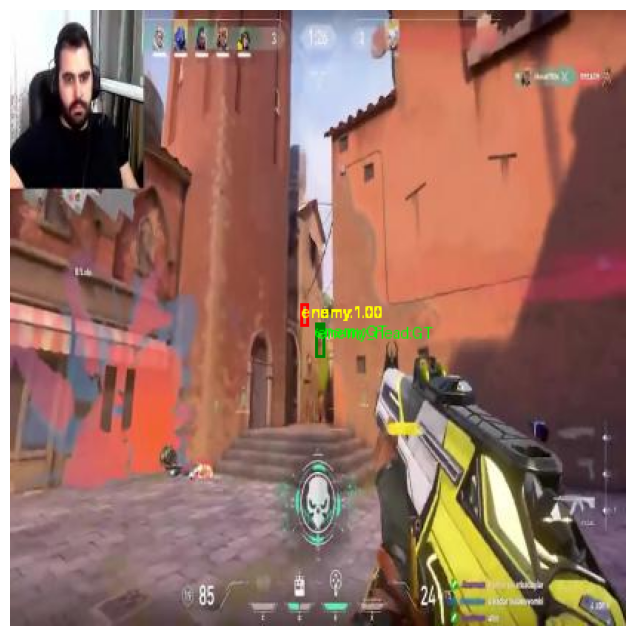

Evaluating:   9%|▉         | 23/258 [00:01<00:09, 23.60it/s]

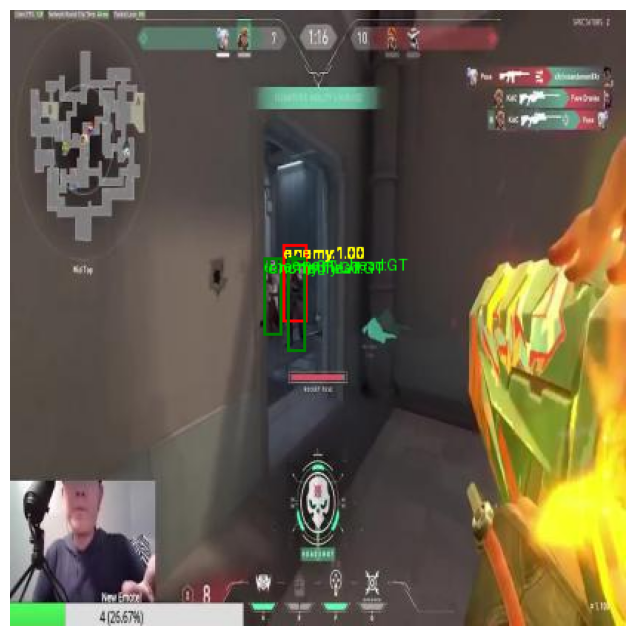

Evaluating:  19%|█▉        | 50/258 [00:02<00:08, 23.92it/s]

Evaluating:  29%|██▊       | 74/258 [00:03<00:07, 23.53it/s]

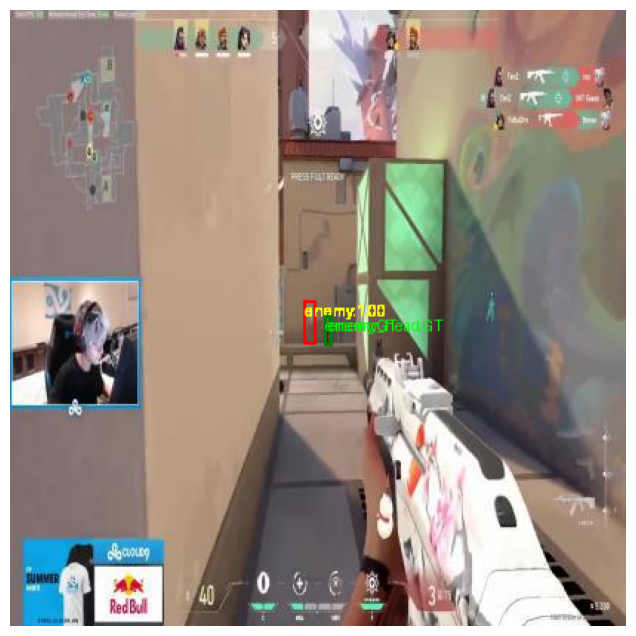

Evaluating:  38%|███▊      | 98/258 [00:05<00:06, 23.70it/s]

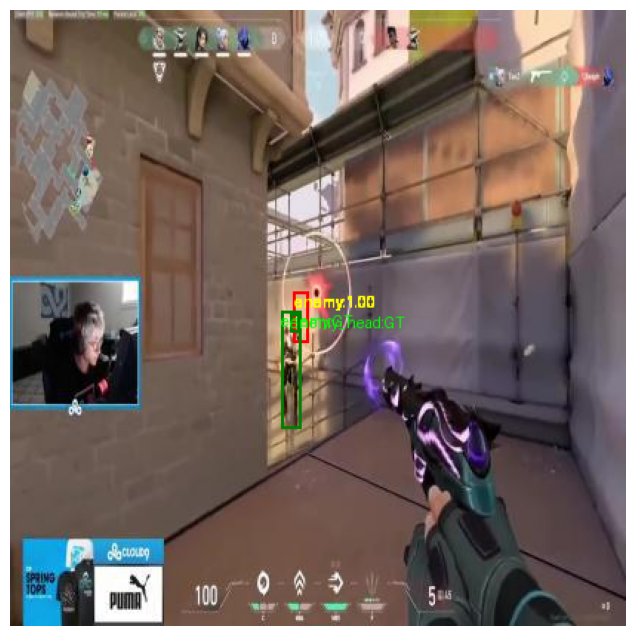

Evaluating:  48%|████▊     | 125/258 [00:06<00:05, 24.23it/s]

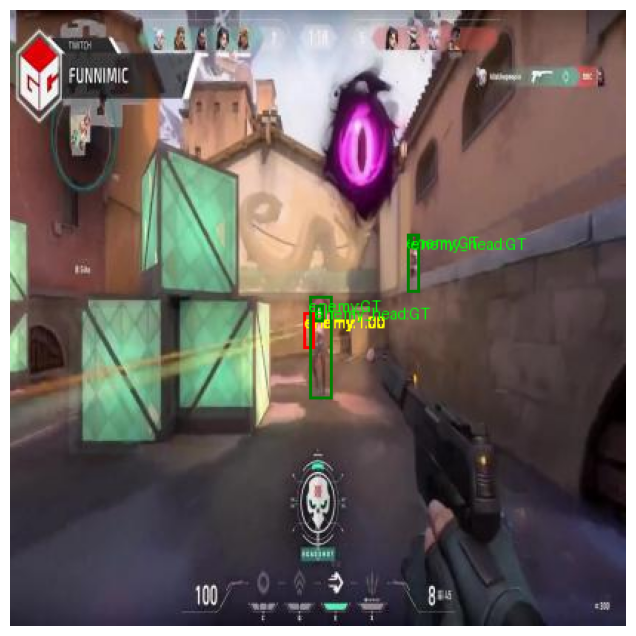

Evaluating:  58%|█████▊    | 149/258 [00:07<00:04, 21.83it/s]

Evaluating:  67%|██████▋   | 173/258 [00:09<00:03, 21.55it/s]

Evaluating:  78%|███████▊  | 200/258 [00:10<00:02, 23.96it/s]

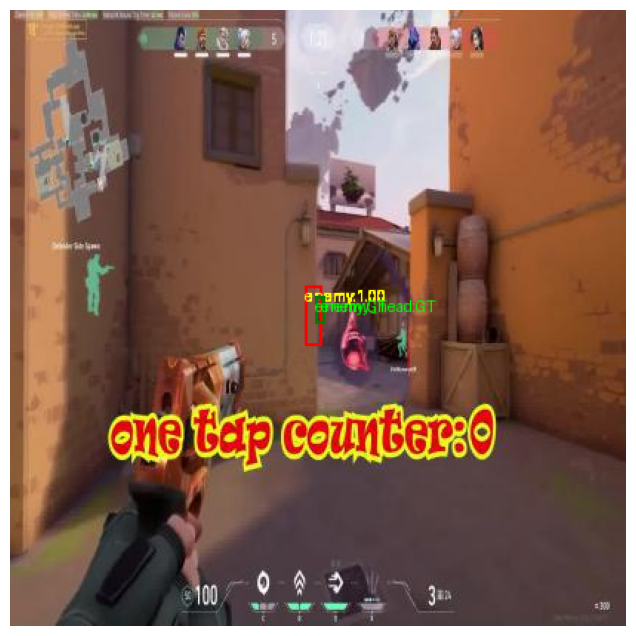

Evaluating:  87%|████████▋ | 224/258 [00:11<00:01, 24.21it/s]

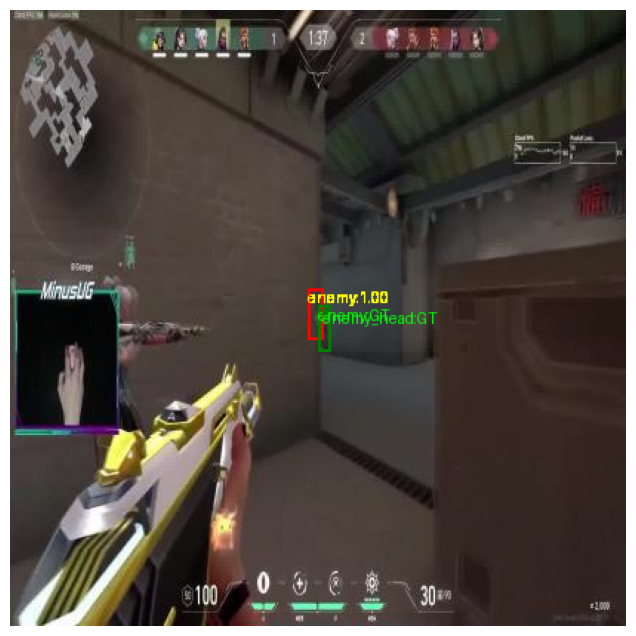

Evaluating:  96%|█████████▌| 248/258 [00:13<00:00, 22.65it/s]

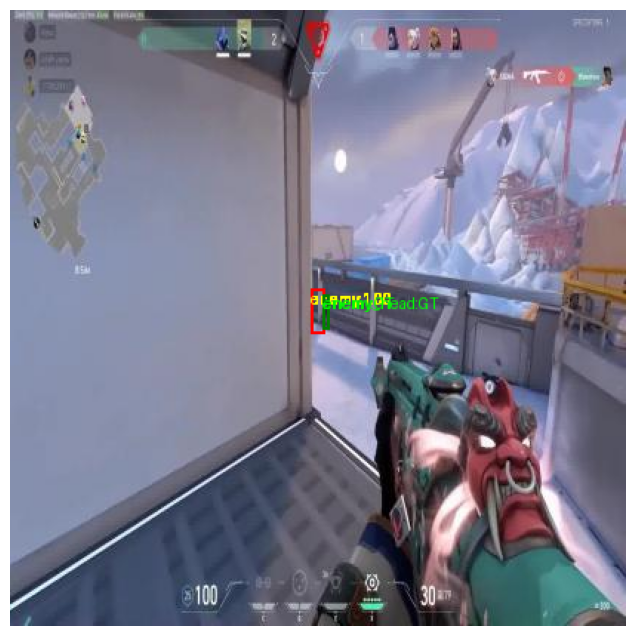

Evaluating: 100%|██████████| 258/258 [00:13<00:00, 18.86it/s]

[tensor(0.3515), tensor(0.5099), tensor(0.3538), tensor(0.4711), tensor(0.4215), tensor(0.3351), tensor(0.5077), tensor(0.5933), tensor(0.3242), tensor(0.4467), tensor(0.5188), tensor(0.7532), tensor(0.5246), tensor(0.3299), tensor(0.4235), tensor(0.5186), tensor(0.5301), tensor(0.3329), tensor(0.4955)]
Precision: 0.004
Recall: 0.031
Mean IoU (mIoU): 0.460
Note: This is not mAP, but you get detection-style precision/recall and mIoU.


In [14]:
import torch
import torchvision
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Model ---
#model = DinoDETR(num_classes=3, num_queries=20)
#model.load_state_dict(torch.load('dino_detr_epoch15_fin_101.pth', map_location=device))
#model.to(device)
model.eval()

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_dataset = ObjectDetectionDataset(
    img_dir='../data/test',
    csv_file='../data/test/_annotations.csv',
    label_encoder=label_encoder,
    transform=test_transform,
    imsize=224
)

precision, recall, mIoU = eval_on_dataset(
    model,
    test_dataset,
    label_encoder,
    device,
    iou_threshold=0.3,
    score_threshold=0.3,
    plot_every=25
)

Unfortunately, the current implementation does not work too well on the task. However, this serves as an attempt to demonstrate and explore the integration of DINO-based Vision Transformers with DETR-style transformer heads for object detection. Our work shows that YOLO models work best!